# Imports

In [53]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import torchvision
import torch

import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [54]:
classes = ["chair" , "aeroplane" , "train" , "motorbike"]

# Run to store data in required folder structure

In [5]:
annotation_directory_path = 'VOC2007/Annotations'
xml_files = os.listdir(annotation_directory_path)

for file in xml_files:
    xml_file_path = annotation_directory_path + '/' + file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    
    # Iterate through the XML elements and save cropped image   
    for object_elem in root.findall('.//object'):
        # Extract the class label
        class_label = object_elem.find('name').text
        if class_label.lower() in classes:
            # Extract the bounding box
            bndbox = object_elem.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Extract the image
            image_path = 'VOC2007/JPEGImages/' + file[:-4] + '.jpg'
            image = cv2.imread(image_path)
            
            # Crop the image
            cropped_image = image[ymin:ymax, xmin:xmax]
            
            # Save the image
            save_path = 'Dataset/train/' + class_label.lower() + '/' + file[:-4] + '.jpg'
            cv2.imwrite(save_path, cropped_image)
    

# Learning

In [77]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((227,227)),
    #torchvision.transforms.RandomResizedCrop(256, scale=(0.85, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

In [78]:
batch_size = 32
num_classes = 4

In [79]:
train_ds  = torchvision.datasets.ImageFolder( "Dataset/train", transform=transform_train) 
train_iter = torch.utils.data.DataLoader( train_ds, batch_size, shuffle=True, drop_last=True)

# Visualise dataset

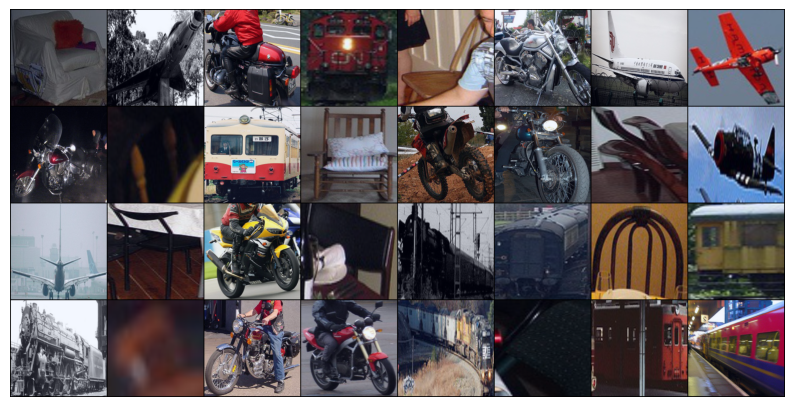

In [80]:
# Sample a batch from train_iter and visualise images and labels
for X, y in train_iter:
    # X is a batch of images

    # Use torchvision's make_grid to create a grid of images for easier visualization
    grid = vutils.make_grid(X, padding=2, normalize=True)

    # Convert the PyTorch tensor to a NumPy array and transpose the dimensions
    grid = grid.permute(1, 2, 0).cpu().numpy()

    # Plot the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

    break

# Model

In [81]:
# Code Alexnet Model from scratch
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4), # 55 x 55
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 27 x 27
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # 27 x 27
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 13 x 13
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # 13 x 13
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # 13 x 13
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 13 x 13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 6 x 6
        )
        self.classifier = nn.Sequential(
            nn.Dropout(), 
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(), 
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [82]:
# Load a pre-trained AlexNet model
model = AlexNet(num_classes=num_classes)

In [83]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cpu')

In [84]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_iter:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_iter)}")


Epoch 1/10, Loss: 1.3765601879212914
Epoch 2/10, Loss: 1.346873146731679
Epoch 3/10, Loss: 1.3032362998985663
Epoch 4/10, Loss: 1.2675752465317889
Epoch 5/10, Loss: 1.2160869720505505
Epoch 6/10, Loss: 1.150515425495985
Epoch 7/10, Loss: 1.1317826393173962
Epoch 8/10, Loss: 1.1038241066583774
Epoch 9/10, Loss: 1.0810106294911082
Epoch 10/10, Loss: 1.0665152901556434
